## 1. The raw data files and their format

<p>While the rate of fatal road accidents has been decreasing steadily since the 80s, the past ten years have seen a stagnation in this reduction. Coupled with the increase in number of miles driven in the nation, the total number of traffic related-fatalities has now reached a ten year high and is rapidly increasing.</p>
<p>Per request of the  Department of Transportation, we are currently investigating how to derive a strategy to reduce the incidence of road accidents across the nation. By looking at the demographics of traﬃc accident victims for each state, we find that there is a lot of variation between states. Now we want to understand if there are patterns in this variation in order to derive suggestions for a policy action plan. In particular, instead of implementing a costly nation-wide plan we want to focus on groups of  states with similar profiles. How can we find such groups in a statistically sound way and communicate the result effectively?</p>
<p>To accomplish these tasks, we will make use of data wrangling, plotting, dimensionality reduction, and unsupervised clustering.</p>


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [1]:
pwd

'C:\\Users\\HP\\Desktop\\road'

In [5]:
cd road

C:\Users\HP\Desktop\road


In [4]:
data=pd.read_csv("road-accidents.csv", sep="|",skiprows=9)

In [5]:
data.head()

,state,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
0,Alabama,18.8,39,30,80
1,Alaska,18.1,41,25,94
2,Arizona,18.6,35,28,96
3,Arkansas,22.4,18,26,95
4,California,12.0,35,28,89


In [6]:
data.describe()

,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
count,51.000000,51.000000,51.000000,51.00000
mean,15.790196,31.725490,30.686275,88.72549
std,4.122002,9.633438,5.132213,6.96011
min,5.900000,13.000000,16.000000,76.00000
25%,12.750000,23.000000,28.000000,83.50000
50%,15.600000,34.000000,30.000000,88.00000
75%,18.500000,38.000000,33.000000,95.00000
max,23.900000,54.000000,44.000000,100.00000


array([[<Axes: title={'center': 'drvr_fatl_col_bmiles'}>,
        <Axes: title={'center': 'perc_fatl_speed'}>],
       [<Axes: title={'center': 'perc_fatl_alcohol'}>,
        <Axes: title={'center': 'perc_fatl_1st_time'}>]], dtype=object)

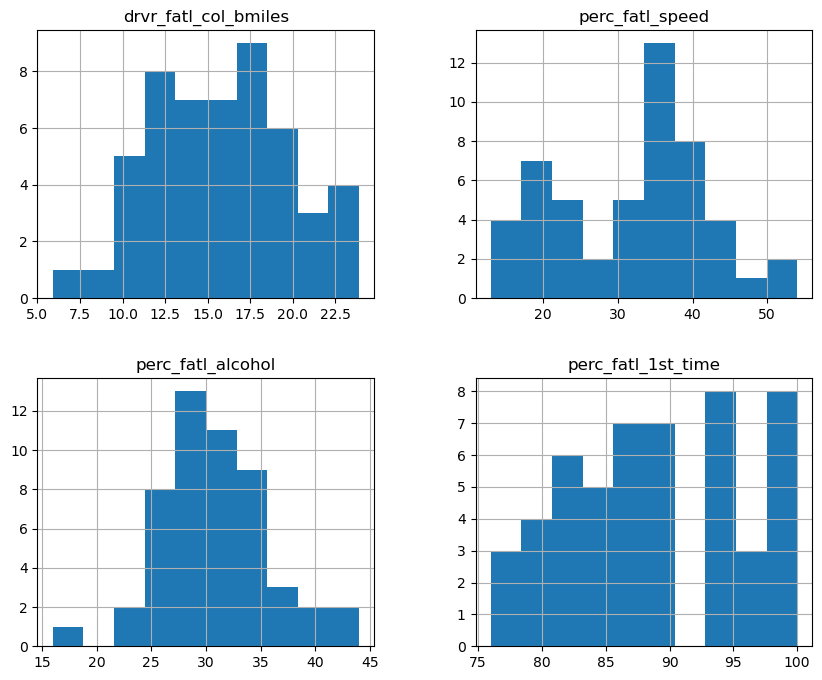

## 2. Read in and get an overview of the data
<p>Next, we will orient ourselves to get to know the data with which we are dealing.</p>

## 3. Create a textual and a graphical summary of the data
<p>We now have an idea of what the dataset looks like. To further familiarize ourselves with this data, we will calculate summary statistics and produce a graphical overview of the data. The graphical overview is good to get a sense for the distribution of variables within the data and could consist of one histogram per column. It is often a good idea to also explore the pairwise relationship between all columns in the data set by using a using pairwise scatter plots (sometimes referred to as a "scatterplot matrix").</p>

array([[<Axes: title={'center': 'drvr_fatl_col_bmiles'}>,
        <Axes: title={'center': 'perc_fatl_speed'}>],
       [<Axes: title={'center': 'perc_fatl_alcohol'}>,
        <Axes: title={'center': 'perc_fatl_1st_time'}>]], dtype=object)

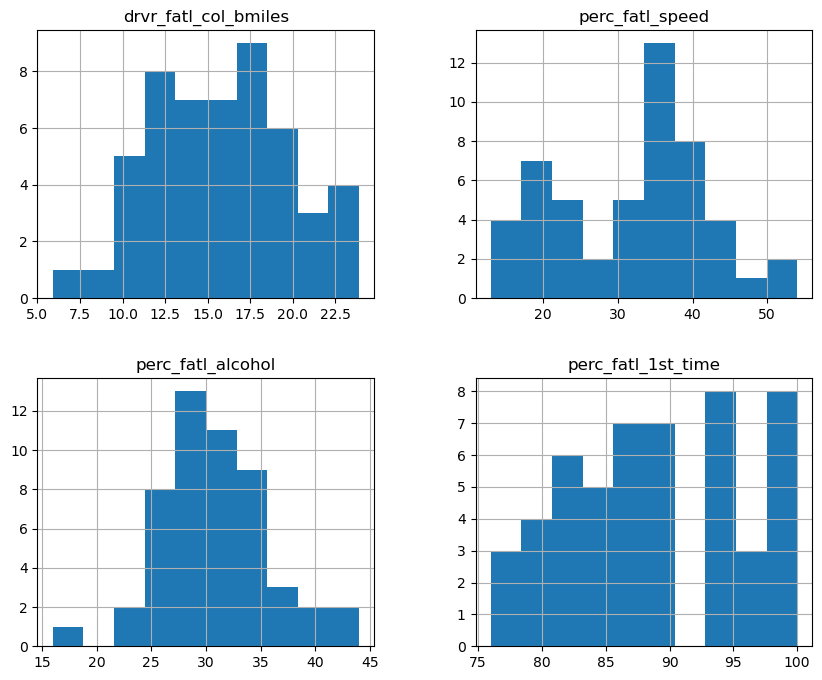

In [7]:
data.hist(figsize=(10,8)) ## in inches

In [8]:
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

In [9]:
plt.show()

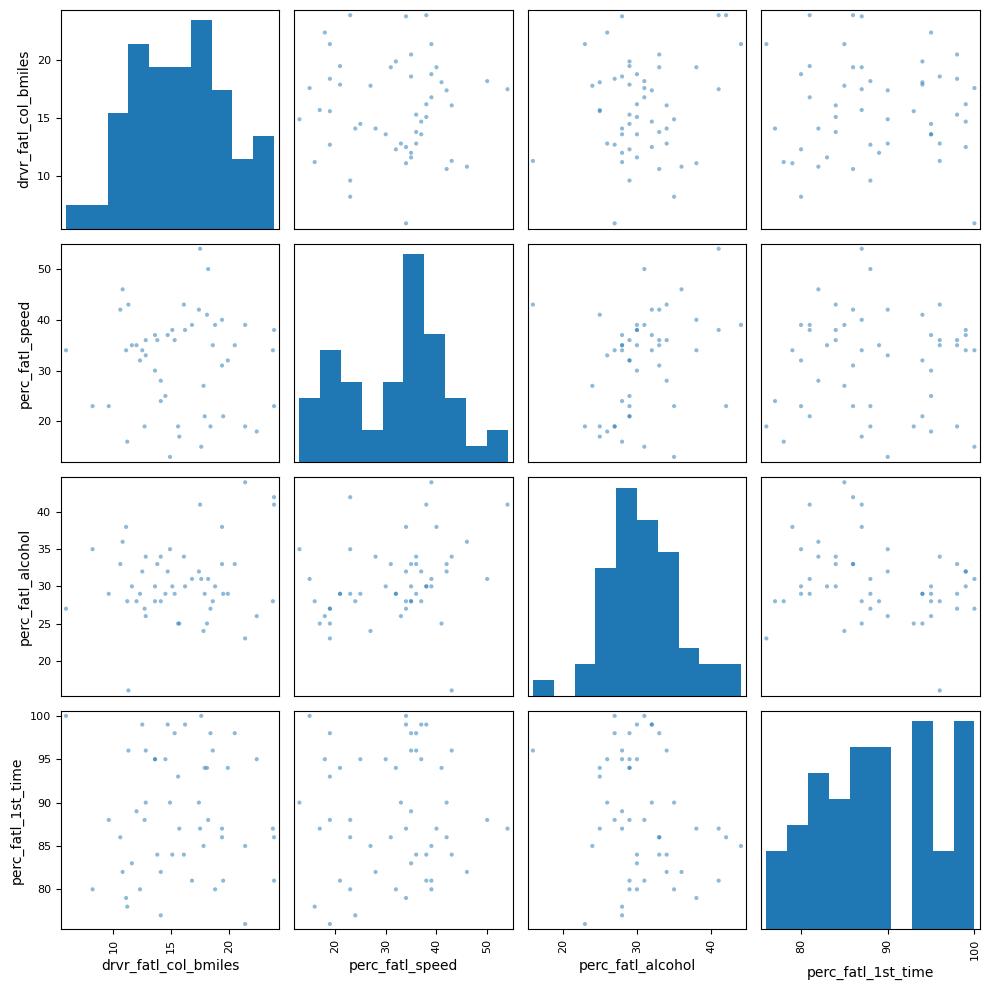

In [10]:
pd.plotting.scatter_matrix(data, figsize=(10, 10))
plt.tight_layout()
plt.show()

## 4. Quantify the association of features and accidents
<p>We can already see some potentially interesting relationships between the target variable (the number of fatal accidents) and the feature variables (the remaining three columns).</p>
<p>To quantify the pairwise relationships that we observed in the scatter plots, we can compute the Pearson correlation coefficient matrix. The Pearson correlation coefficient is one of the most common methods to quantify correlation between variables, and by convention, the following thresholds are usually used:</p>
<ul>
<li>0.2 = weak</li>
<li>0.5 = medium</li>
<li>0.8 = strong</li>
<li>0.9 = very strong</li>
</ul>

In [22]:
correlation_matrix = data.corr()
print(correlation_matrix)

                      drvr_fatl_col_bmiles  perc_fatl_speed  \
drvr_fatl_col_bmiles              1.000000        -0.029080   
perc_fatl_speed                  -0.029080         1.000000   
perc_fatl_alcohol                 0.199426         0.286244   
perc_fatl_1st_time               -0.017942         0.014066   

                      perc_fatl_alcohol  perc_fatl_1st_time  
drvr_fatl_col_bmiles           0.199426           -0.017942  
perc_fatl_speed                0.286244            0.014066  
perc_fatl_alcohol              1.000000           -0.245455  
perc_fatl_1st_time            -0.245455            1.000000  


C:\Users\HP\AppData\Local\Temp\ipykernel_3632\4203189485.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


## 5. Fit a multivariate linear regression
<p>From the correlation table, we see that the amount of fatal accidents is most strongly correlated with alcohol consumption (first row). But in addition, we also see that some of the features are correlated with each other, for instance, speeding and alcohol consumption are positively correlated. We, therefore, want to compute the association of the target with each feature while adjusting for the effect of the remaining features. This can be done using multivariate linear regression.</p>
<p>Both the multivariate regression and the correlation measure how strongly the features are associated with the outcome (fatal accidents). When comparing the regression coefficients with the correlation coefficients, we will see that they are slightly different. The reason for this is that the multiple regression computes the association of a feature with an outcome, given the association with all other features, which is not accounted for when calculating the correlation coefficients.</p>
<p>A particularly interesting case is when the correlation coefficient and the regression coefficient of the same feature have opposite signs. How can this be? For example, when a feature A is positively correlated with the outcome Y but also positively correlated with a different feature B that has a negative effect on Y, then the indirect correlation (A-&gt;B-&gt;Y) can overwhelm the direct correlation (A-&gt;Y). In such a case, the regression coefficient of feature A could be positive, while the correlation coefficient is negative. This is sometimes called a <em>masking</em> relationship. Let’s see if the multivariate regression can reveal such a phenomenon.</p>

In [11]:
from sklearn.linear_model import LinearRegression

X = data[['perc_fatl_speed', 'perc_fatl_alcohol', 'perc_fatl_1st_time']]
y = data['drvr_fatl_col_bmiles']

regression_model = LinearRegression()
regression_model.fit(X, y)

LinearRegression()

In [13]:
print("Intercept:", regression_model.intercept_)
print("Coefficients:", regression_model.coef_)

Intercept: 9.064980483403303
Coefficients: [-0.04180041  0.19086404  0.02473301]


## 6. Perform PCA on standardized data
<p>We have learned that alcohol consumption is weakly associated with the number of fatal accidents across states. This could lead us to conclude that alcohol consumption should be a focus for further investigations and maybe strategies should divide states into high versus low alcohol consumption in accidents. But there are also associations between  alcohol consumptions and the other two features, so it might be worth trying to split the states in a way that accounts for all three features.</p>
<p>One way of clustering the data is to use PCA to visualize data in reduced dimensional space where we can try to pick up patterns by eye. PCA uses the absolute variance to calculate the overall variance explained for each principal component, so it is important that the features are on a similar scale (unless we would have a particular reason that one feature should be weighted more).</p>
<p>We'll use the appropriate scaling function to standardize the features to be centered with mean 0 and scaled with standard deviation 1.</p>

In [16]:
X.shape

(51, 3)

In [51]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

pca = PCA(0.79)
principal_components = pca.fit_transform(scaled_data)

In [52]:
principal_components.shape

(51, 2)

In [53]:
# Get the PCA components
pca_components = pca.components_

# Print the PCA components
print("PCA Components:")
print(pca_components)

PCA Components:
[[ 0.53455662  0.71358084 -0.45282624]
 [-0.65077841  0.00570541 -0.75924627]]


In [55]:
explained_variance_ratio = pca.explained_variance_ratio_

In [56]:
explained_variance_ratio

array([0.4567308 , 0.33796706])

In [58]:
# Find the number of components needed to explain 79% of the variance
total_variance = 0
num_components = 0
for i, explained_var in enumerate(explained_variance_ratio):
    total_variance += explained_var
    num_components += 1
    if total_variance >= 0.79:
        break

# Get the column names corresponding to the selected components
selected_columns = X.columns[:num_components]

# Print the names of columns that contributed to 79% of the variation in PCA
print("Columns Contributing to 79% Variation in PCA:")
print(selected_columns)



Columns Contributing to 79% Variation in PCA:
Index(['perc_fatl_speed', 'perc_fatl_alcohol'], dtype='object')


## 7. Visualize the first two principal components
<p>The first two principal components enable visualization of the data in two dimensions while capturing a high proportion of the variation (79%) from all three features: speeding, alcohol influence, and first-time accidents. This enables us to use our eyes to try to discern patterns in the data with the goal to find groups of similar states. Although clustering algorithms are becoming increasingly efficient, human pattern recognition is an easily accessible and very efficient method of assessing patterns in data.</p>
<p>We will create a scatter plot of the first principle components and explore how the states cluster together in this visualization.</p>

In [26]:
principal_components[:, 0]

array([ 0.88463912, -0.62529903, -0.67169596, -1.83954608, -0.21174283,
       -0.49390467,  1.98805561, -0.41984695, -1.13099129, -1.18444358,
       -1.79251216,  2.80996806, -0.60664618,  0.2268846 , -1.02598376,
       -1.51035032, -0.95893975, -0.95632936, -0.10099555,  0.56576691,
       -0.36316811,  0.6900851 , -0.03971211, -0.67811433, -1.63409399,
        1.40766864,  2.52202483, -0.52740931, -0.19504256,  0.46334895,
       -0.5537545 , -1.84020388,  0.35192305,  0.95935465,  1.27880139,
        0.69845606, -0.56798322, -0.67038036,  1.11586188,  1.79352241,
        2.30754399,  0.46332813, -0.3302449 ,  1.60411279, -1.90843858,
       -0.60535139, -1.18312797,  1.07978849, -0.1363695 ,  0.87495256,
        0.67653501])

In [27]:
pca.explained_variance_ratio_

array([0.4567308 , 0.33796706])

In [28]:
pca.n_components_

2

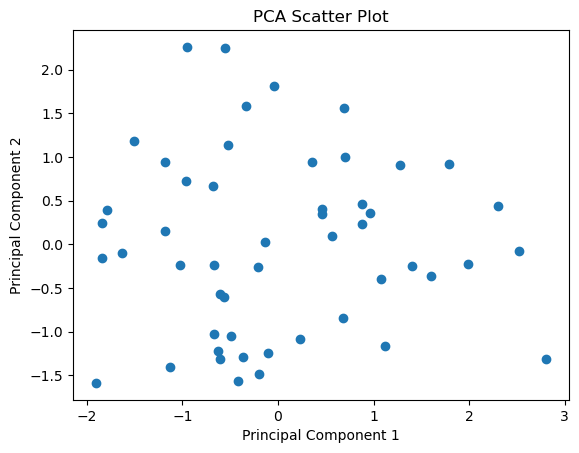

In [25]:
plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot")
plt.show()

## 8. Find clusters of similar states in the data
<p>It was not entirely clear from the PCA scatter plot how many groups in which the states cluster. To assist with identifying a reasonable number of clusters, we can use KMeans clustering by creating a scree plot and finding the "elbow", which is an indication of when the addition of more clusters does not add much explanatory power.</p>

D:\program\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\program\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\program\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\program\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\progr

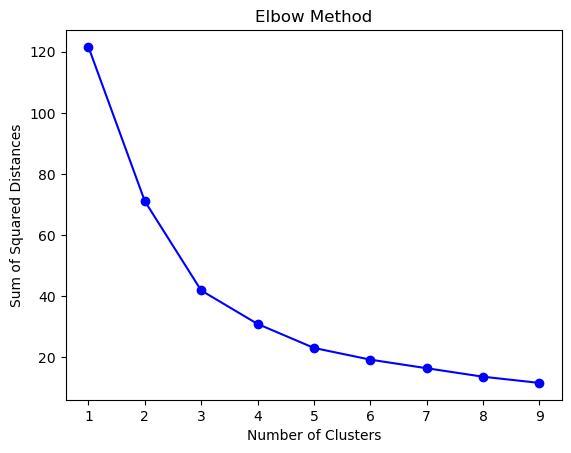

In [29]:
sse = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(principal_components[:, :2])
    sse.append(kmeans.inertia_)

plt.plot(k_range, sse, 'bo-')
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Distances")
plt.title("Elbow Method")
plt.show()

## 9. KMeans to visualize clusters in the PCA scatter plot
<p>Since there wasn't a clear elbow in the scree plot, assigning the states to either two or three clusters is a reasonable choice, and we will resume our analysis using three clusters. Let's see how the PCA scatter plot looks if we color the states according to the cluster to which they are assigned.</p>

In [30]:
kmeans.labels_

array([4, 2, 2, 8, 0, 2, 7, 2, 2, 8, 8, 6, 2, 1, 0, 3, 3, 5, 2, 4, 2, 4,
       5, 3, 8, 7, 7, 3, 2, 4, 5, 8, 4, 4, 4, 4, 0, 0, 1, 4, 7, 4, 5, 7,
       2, 0, 3, 1, 0, 4, 1])

D:\program\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\program\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


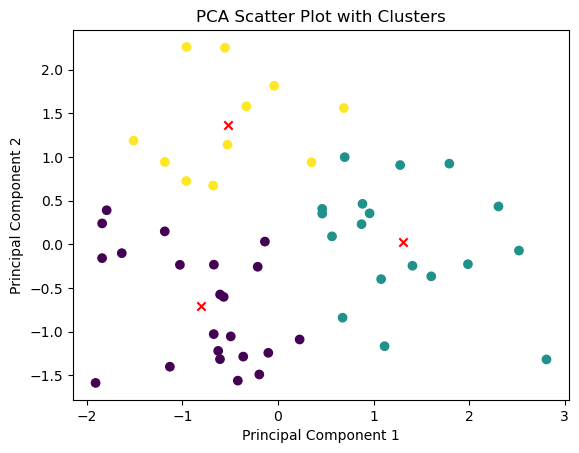

In [31]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(principal_components[:, :2])

plt.scatter(principal_components[:, 0], principal_components[:, 1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot with Clusters")
plt.show()

## 10. Visualize the feature differences between the clusters
<p>Thus far, we have used both our visual interpretation of the data and the KMeans clustering algorithm to reveal patterns in the data, but what do these patterns mean?</p>
<p>Remember that the information we have used to cluster the states into three distinct groups are the percentage of drivers speeding, under alcohol influence and that has not previously been involved in an accident. We used these clusters to visualize how the states group together when considering the first two principal components. This is good for us to understand structure in the data, but not always easy to understand, especially not if the findings are to be communicated to a non-specialist audience.</p>
<p>A reasonable next step in our analysis is to explore how the three clusters are different in terms of the three features that we used for clustering. Instead of using the scaled features, we return to using the unscaled features to help us interpret the differences.</p>

In [49]:
kmeans.labels_

array([2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 0, 1, 2, 1, 0,
       0, 0, 1, 2, 2, 0, 1, 2, 0, 1, 0, 2, 2, 0, 1, 1, 2, 2, 2, 2, 0, 2,
       1, 1, 0, 2, 1, 2, 2])

In [32]:
data['Cluster'] = kmeans.labels_
data.head()

,state,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time,Cluster
0,Alabama,18.8,39,30,80,1
1,Alaska,18.1,41,25,94,0
2,Arizona,18.6,35,28,96,0
3,Arkansas,22.4,18,26,95,0
4,California,12.0,35,28,89,0


In [34]:
X.columns

Index(['perc_fatl_speed', 'perc_fatl_alcohol', 'perc_fatl_1st_time'], dtype='object')

In [36]:
for i, col in enumerate(X.columns):
    print(i)
    print(col)

0
perc_fatl_speed
1
perc_fatl_alcohol
2
perc_fatl_1st_time


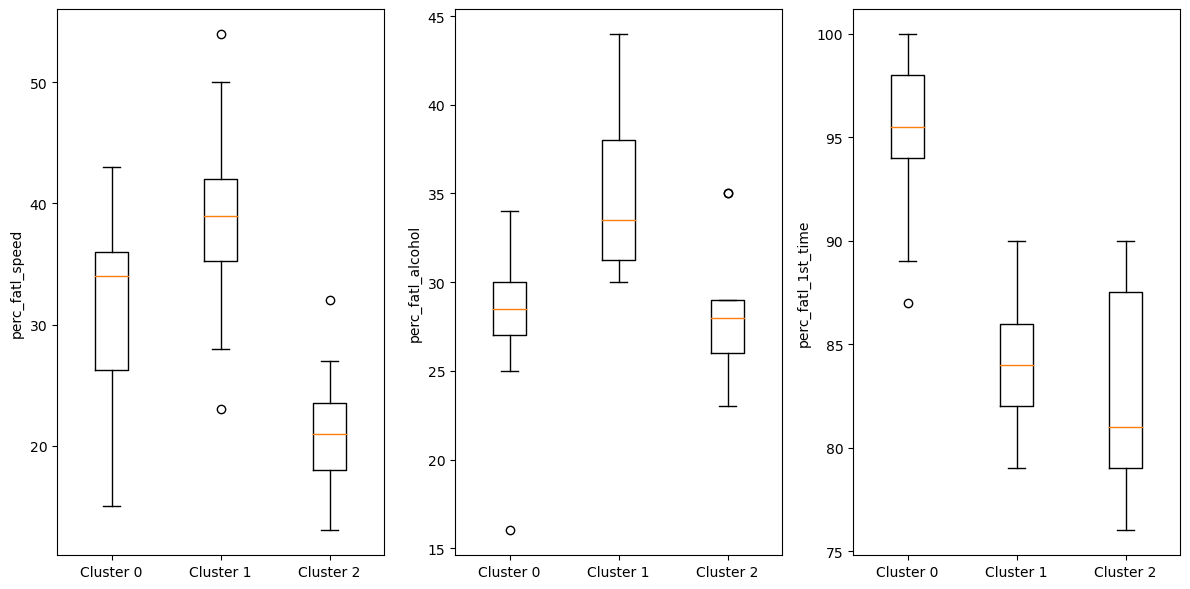

In [39]:

plt.figure(figsize=(12, 6))
for i, col in enumerate(X.columns):
    plt.subplot(1, 3, i+1)
    plt.boxplot([data[data['Cluster'] == 0][col],
                 data[data['Cluster'] == 1][col],
                 data[data['Cluster'] == 2][col]])
    plt.xticks([1, 2, 3], ['Cluster 0', 'Cluster 1', 'Cluster 2'])
    plt.ylabel(col)

plt.tight_layout()
plt.show()

In [46]:
# data['Clusters'] = kmeans.fit_predict(principal_components)

D:\program\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\program\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [48]:
# data

,state,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time,Cluster,Clusters
0,Alabama,18.8,39,30,80,1,2
1,Alaska,18.1,41,25,94,0,1
2,Arizona,18.6,35,28,96,0,1
3,Arkansas,22.4,18,26,95,0,1
4,California,12.0,35,28,89,0,1
5,Colorado,13.6,37,28,95,0,1
6,Connecticut,10.8,46,36,82,1,2
7,Delaware,16.2,38,30,99,0,1
8,District of Columbia,5.9,34,27,100,0,1
9,Florida,17.9,21,29,94,0,1


## 11. Compute the number of accidents within each cluster
<p>Now it is clear that different groups of states may require different interventions. Since resources and time are limited, it is useful to start off with an intervention in one of the three groups first. Which group would this be? To determine this, we will include data on how many miles are driven in each state, because this will help us to compute the total number of fatal accidents in each state. Data on miles driven is available in another tab-delimited text file. We will assign this new information to a column in the DataFrame and create a violin plot for how many total fatal traffic accidents there are within each state cluster.</p>

In [40]:
cluster_counts = data.groupby('Cluster')['drvr_fatl_col_bmiles'].sum()
print(cluster_counts)

Cluster
0    348.0
1    299.9
2    157.4
Name: drvr_fatl_col_bmiles, dtype: float64


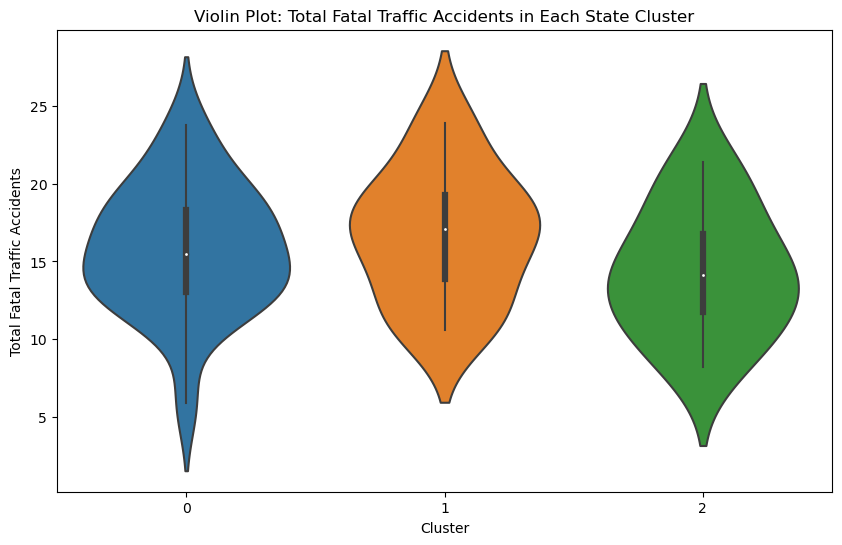

In [45]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Cluster', y='drvr_fatl_col_bmiles', data=data)
plt.xlabel("Cluster")
plt.ylabel("Total Fatal Traffic Accidents")
plt.title("Violin Plot: Total Fatal Traffic Accidents in Each State Cluster")
plt.show()

## 12. Make a decision when there is no clear right choice
<p>As we can see, there is no obvious correct choice regarding which cluster is the most important to focus on. Yet, we can still argue for a certain cluster and motivate this using our findings above. Which cluster do you think should be a focus for policy intervention and further investigation?</p>

In [42]:
total_accidents = cluster_counts.sum()

# Calculate the percentage of accidents in each cluster
cluster_percentages = (cluster_counts / total_accidents)*100

# Print the percentage of accidents in each cluster
print("Percentage of accidents in each cluster:")
print(cluster_percentages)


Percentage of accidents in each cluster:
Cluster
0    43.213709
1    37.240780
2    19.545511
Name: drvr_fatl_col_bmiles, dtype: float64
